# Vision-Based Pedestrian Detection for Self-Driving Cars

## 1.Faster Region-based Convolutional Neural Network

In [2]:
#Import all the tools we need
import os
import json
import random
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

#Configuration & Hyperparameters
SEED        = 42
IMG_DIR     = "images"                          
ANN_FILE    = "coco_annotations_final.json"  
BATCH_SIZE  = 4
NUM_CLASSES = 2   
NUM_EPOCHS  = 10
LR          = 5e-4

random.seed(SEED)
torch.manual_seed(SEED)

#Use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Custom Dataset class to load images and their annotations
class CocoAttrDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.img_dir = img_dir
        data = json.load(open(ann_file))

        # Create mapping from image ID to file name
        self.id2fn = {img["id"]: img["file_name"] for img in data["images"]}

        # Group annotations by image ID, keeping only pedestrians
        self.anns = {}
        for ann in data.get("annotations", []):
            if ann["category_id"] == 1:
                self.anns.setdefault(ann["image_id"], []).append(ann)

        self.ids = list(self.id2fn.keys())
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        fn     = self.id2fn[img_id]
        path   = os.path.join(self.img_dir, fn)

        if not os.path.isfile(path):
            return None

        # Load and convert image to RGB
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Get annotations for this image
        target_anns = self.anns.get(img_id, [])
        boxes, labels, attrs = [], [], []

        for ann in target_anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(1)
            attrs.append(ann.get("attributes", {}))

        # Convert to tensors
        if boxes:
            boxes  = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes  = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "attributes": attrs
        }
        return img, target

In [ ]:
# Collate function to skip invalid/missing samples
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return [], []
    return tuple(zip(*batch))

In [ ]:
# Apply basic transform to convert image to tensor
transform = transforms.Compose([transforms.ToTensor()])
dataset = CocoAttrDataset(IMG_DIR, ANN_FILE, transform=transform)

In [ ]:
# Split the dataset into training and validation sets
idxs = list(range(len(dataset)))
random.shuffle(idxs)
split = int(0.8 * len(idxs))
train_idxs, val_idxs = idxs[:split], idxs[split:]

In [ ]:
# Create DataLoaders for training and validation
train_loader = DataLoader(
    torch.utils.data.Subset(dataset, train_idxs),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=safe_collate,
    num_workers=4
)
val_loader = DataLoader(
    torch.utils.data.Subset(dataset, val_idxs),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=safe_collate,
    num_workers=4
)

In [ ]:
# Load  Faster R-CNN and replace classification head
improved_cnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_feats = improved_cnn_model.roi_heads.box_predictor.cls_score.in_features
improved_cnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, NUM_CLASSES)
improved_cnn_model.to(device)

In [ ]:
# Set up optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(improved_cnn_model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [5]:
# Training and validation loop
for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    improved_cnn_model.train()
    train_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [TRAIN]"):
        if not images:
            continue

        imgs = [img.to(device) for img in images]

        # Remove "attributes" field before loss calculation
        targs = [{k: v.to(device) for k, v in t.items() if k != "attributes"} for t in targets]

        loss_dict = improved_cnn_model(imgs, targs)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    lr_scheduler.step()
    avg_train = train_loss / max(len(train_loader), 1)
    print(f"[Epoch {epoch}] Train loss: {avg_train:.4f}")

    # Validation phase
    improved_cnn_model.eval()
    total_dets = 0
    total_imgs = 0

    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [VAL]"):
            if not images:
                continue
            imgs = [img.to(device) for img in images]
            outputs = improved_cnn_model(imgs)

            for out in outputs:
                total_dets += (out["scores"] > 0.5).sum().item()
                total_imgs += 1

    avg_det = total_dets / max(total_imgs, 1)
    print(f"[Epoch {epoch}] Avg detections/image: {avg_det:.2f}")

# Save the trained model to disk
torch.save(improved_cnn_model.state_dict(), "improvedrrcnn_full.pth")
print("Model saved to improvedrrcnn_full.pth")

Epoch 1/10 [TRAIN]: 100%|██████████| 16407/16407 [07:56<00:00, 34.44it/s]


[Epoch 1] Train loss: 0.0492


Epoch 1/10 [VAL]: 100%|██████████| 4102/4102 [01:37<00:00, 41.86it/s]


[Epoch 1] Avg detections/image: 2.38


Epoch 2/10 [TRAIN]: 100%|██████████| 16407/16407 [10:00<00:00, 27.32it/s]


[Epoch 2] Train loss: 0.0399


Epoch 2/10 [VAL]: 100%|██████████| 4102/4102 [01:43<00:00, 39.58it/s]


[Epoch 2] Avg detections/image: 2.79


Epoch 3/10 [TRAIN]: 100%|██████████| 16407/16407 [10:01<00:00, 27.26it/s]


[Epoch 3] Train loss: 0.0363


Epoch 3/10 [VAL]: 100%|██████████| 4102/4102 [01:43<00:00, 39.71it/s]


[Epoch 3] Avg detections/image: 0.97


Epoch 4/10 [TRAIN]: 100%|██████████| 16407/16407 [08:11<00:00, 33.38it/s]


[Epoch 4] Train loss: 0.0341


Epoch 4/10 [VAL]: 100%|██████████| 4102/4102 [01:13<00:00, 56.08it/s]


[Epoch 4] Avg detections/image: 1.72


Epoch 5/10 [TRAIN]: 100%|██████████| 16407/16407 [07:10<00:00, 38.13it/s]


[Epoch 5] Train loss: 0.0316


Epoch 5/10 [VAL]: 100%|██████████| 4102/4102 [01:13<00:00, 55.85it/s]


[Epoch 5] Avg detections/image: 3.58


Epoch 6/10 [TRAIN]: 100%|██████████| 16407/16407 [07:08<00:00, 38.29it/s]


[Epoch 6] Train loss: 0.0195


Epoch 6/10 [VAL]: 100%|██████████| 4102/4102 [01:12<00:00, 56.68it/s]


[Epoch 6] Avg detections/image: 1.62


Epoch 7/10 [TRAIN]: 100%|██████████| 16407/16407 [08:16<00:00, 33.06it/s]


[Epoch 7] Train loss: 0.0174


Epoch 7/10 [VAL]: 100%|██████████| 4102/4102 [01:12<00:00, 56.36it/s]


[Epoch 7] Avg detections/image: 1.59


Epoch 8/10 [TRAIN]: 100%|██████████| 16407/16407 [09:28<00:00, 28.84it/s]


[Epoch 8] Train loss: 0.0164


Epoch 8/10 [VAL]: 100%|██████████| 4102/4102 [03:46<00:00, 18.14it/s]


[Epoch 8] Avg detections/image: 1.60


Epoch 9/10 [TRAIN]: 100%|██████████| 16407/16407 [19:32<00:00, 13.99it/s]


[Epoch 9] Train loss: 0.0154


Epoch 9/10 [VAL]: 100%|██████████| 4102/4102 [01:12<00:00, 56.47it/s]


[Epoch 9] Avg detections/image: 1.58


Epoch 10/10 [TRAIN]: 100%|██████████| 16407/16407 [07:07<00:00, 38.37it/s]


[Epoch 10] Train loss: 0.0135


Epoch 10/10 [VAL]: 100%|██████████| 4102/4102 [01:12<00:00, 56.45it/s]


[Epoch 10] Avg detections/image: 1.54
Model saved to improvedrrcnn_full.pth


In [ ]:
# Function to run inference on an image and visualize predictions + ground truth
def infer_and_plot(path, target=None, thresh=0.6):

    img = Image.open(path).convert("RGB")
    img_t = transform(img).to(device)

    model.eval()
    with torch.no_grad():
        out = model([img_t])[0]

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(img)

    # Draw ground truth boxes (if provided) in red
    if target is not None:
        for (x1, y1, x2, y2), attr in zip(target["boxes"], target["attributes"]):
            r = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                  linewidth=2, edgecolor='r',
                                  facecolor='none', linestyle='--')
            ax.add_patch(r)
            txt = f"{attr.get('action', '')}, occl:{attr.get('occlusion', '')}"
            ax.text(x1, y1 - 8, txt,
                    color='white',
                    bbox=dict(facecolor='r', alpha=0.7, pad=1))

    # Draw predicted boxes in green
    for box, score, lbl in zip(out["boxes"], out["scores"], out["labels"]):
        if lbl.item() != 1 or score < thresh:
            continue
        x1, y1, x2, y2 = box.cpu().tolist()
        r = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              linewidth=2, edgecolor='lime',
                              facecolor='none')
        ax.add_patch(r)
        ax.text(x1, y2 + 3, f"{score:.2f}",
                color='white',
                bbox=dict(facecolor='lime', alpha=0.7, pad=1))

    ax.axis("off")
    plt.show()

### Testing

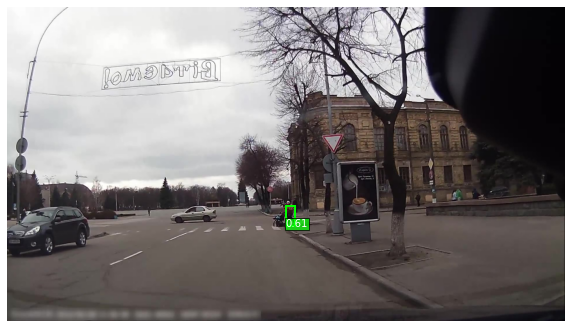

In [7]:
%matplotlib inline
infer_and_plot("test3.jpg")

In [8]:
improved_cnn_model.load_state_dict(torch.load("improvedrrcnn_full.pth", map_location=device))
improved_cnn_model.to(device)
improved_cnn_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
from torchvision.ops import box_iou
import time
def evaluate_model(model, val_loader, device, iou_thresh=0.5, conf_thresh=0.5, fps_test_images=20):
    # Set model to evaluation mode
    model.eval()

    # Initialize counters for metrics
    total_TP, total_FP, total_FN = 0, 0, 0
    iou_scores = []
    total_images = 0

    # Turn off gradient calculations during evaluation
    with torch.no_grad():
        # Loop through validation data
        for images, targets in tqdm(val_loader, desc="Evaluating"):
            if not images:  # Skip if the batch is empty
                continue

            # Move images to the device (GPU/CPU)
            images = [img.to(device) for img in images]
            outputs = model(images)  # Get model predictions

            # Loop over each prediction and its corresponding ground truth
            for out, tgt in zip(outputs, targets):
                # Filter predictions with confidence above threshold
                pred_boxes = out['boxes'][out['scores'] > conf_thresh].cpu()
                gt_boxes   = tgt['boxes'].cpu()

                # Handle edge cases: no predictions and/or no ground truth
                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue
                if len(gt_boxes) == 0:
                    total_FP += len(pred_boxes)
                    continue
                if len(pred_boxes) == 0:
                    total_FN += len(gt_boxes)
                    continue

                # Calculate IoU between predicted and ground-truth boxes
                ious = box_iou(pred_boxes, gt_boxes)
                iou_scores.append(ious.mean().item())

                # Match predicted boxes to ground truth boxes based on IoU
                matched_gt = set()
                for pbox in pred_boxes:
                    ious = box_iou(pbox.unsqueeze(0), gt_boxes)
                    max_iou, idx = ious.max(1)
                    if max_iou.item() >= iou_thresh and idx.item() not in matched_gt:
                        total_TP += 1
                        matched_gt.add(idx.item())
                    else:
                        total_FP += 1
                total_FN += len(gt_boxes) - len(matched_gt)
                total_images += 1

    # Compute evaluation metrics
    precision = total_TP / (total_TP + total_FP + 1e-6)
    recall    = total_TP / (total_TP + total_FN + 1e-6)
    f1_score  = 2 * (precision * recall) / (precision + recall + 1e-6)
    accuracy  = total_TP / (total_TP + total_FP + total_FN + 1e-6)
    avg_iou   = sum(iou_scores) / len(iou_scores) if iou_scores else 0.0

    # Measure average inference speed (FPS) on a small batch
    total_time, total_fps_images = 0, 0
    with torch.no_grad():
        for images, _ in val_loader:
            if not images:
                continue
            images = [img.to(device) for img in images]
            start = time.time()
            _ = model(images)
            end = time.time()
            total_time += (end - start)
            total_fps_images += len(images)
            if total_fps_images >= fps_test_images:
                break
    fps = total_fps_images / total_time if total_time > 0 else 0.0

    # Print the results
    print(f"\n Evaluation Metrics:")
    print(f"Avg IoU     : {avg_iou:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-Score    : {f1_score:.4f}")
    print(f"Accuracy    : {accuracy:.4f}")
    print(f"Inference FPS (on {total_fps_images} imgs): {fps:.2f}")
    
    # Return metrics as a dictionary for logging or saving
    return {
        "avg_iou": avg_iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "accuracy": accuracy,
        "fps": fps
    }


In [14]:
# Evaluate the trained model on the validation set and store the metrics
metrics = evaluate_model(improved_cnn_model, val_loader, device)


Evaluating: 100%|██████████| 4102/4102 [01:11<00:00, 57.29it/s]



 Evaluation Metrics:
Avg IoU     : 0.6368
Precision   : 0.9463
Recall      : 0.9422
F1-Score    : 0.9442
Accuracy    : 0.8943
Inference FPS (on 21 imgs): 35.38


## 2.Histogram of Oriented Gradients(HOG)

HOG+SVM detects objects by analyzing edge directions (gradients) and classifying them with an SVM. It’s more robust than methods like Haar and works well for detecting pedestrians but is slower and less accurate than deep learning models.

In [25]:
from torchvision.ops import box_iou  # Used to compare predicted boxes with ground truth boxes
from tqdm import tqdm  # Just for showing a progress bar during evaluation
import cv2

def build_gt_boxes_dict(coco_json):
    with open(coco_json, 'r') as f:
        data = json.load(f)

    # Step 1: Map image_id → filename
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}

    # Step 2: Create filename → list of gt boxes
    gt_boxes_dict = {}

    for ann in data['annotations']:
        if ann['category_id'] != 1:  # Only pedestrian class
            continue

        img_id = ann['image_id']
        fname = id_to_filename.get(img_id)
        if not fname:
            continue

        x, y, w, h = ann['bbox']
        x2, y2 = x + w, y + h
        box = torch.tensor([x, y, x2, y2], dtype=torch.float32)

        gt_boxes_dict.setdefault(fname, []).append(box)

    return gt_boxes_dict

gt_boxes_dict = build_gt_boxes_dict("coco_annotations_final.json")


def evaluate_hog_detector(img_dir, image_list, gt_boxes_dict, iou_thresh=0.5):
    # Set up the HOG person detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    # Initialize counters for evaluation metrics
    TP = FP = FN = 0  # True Positives, False Positives, False Negatives
    total_time = 0    # To measure how fast detection runs
    total_iou = []    # To store how much predicted boxes overlap with ground truth

    # Go through each image and evaluate detection
    for fname in tqdm(image_list, desc="HOG Evaluation"):
        img_path = os.path.join(img_dir, fname)

        if not os.path.isfile(img_path):
            continue  # Skip if image doesn't exist

        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip if image couldn't be read

        # Run the detector and measure time taken
        start = time.time()
        rects, _ = hog.detectMultiScale(img)  # Get predicted boxes
        end = time.time()
        total_time += (end - start)

        # Convert predictions to the format [x1, y1, x2, y2]
        pred_boxes = [torch.tensor([x, y, x + w, y + h], dtype=torch.float32) for (x, y, w, h) in rects]
        pred_boxes = torch.stack(pred_boxes).to(device) if pred_boxes else torch.zeros((0, 4), device=device)

        # Get ground truth boxes for this image
        gt_boxes = gt_boxes_dict.get(fname, [])
        gt_boxes = torch.stack(gt_boxes) if gt_boxes else torch.zeros((0, 4))

        # Handle different cases: no predictions or no ground truth
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            continue  # Nothing to compare
        if len(gt_boxes) == 0:
            FP += len(pred_boxes)  # All predictions are false positives
            continue
        if len(pred_boxes) == 0:
            FN += len(gt_boxes)  # All ground truth boxes are missed
            continue

        # Compare predictions with ground truth using IoU
        ious = box_iou(pred_boxes, gt_boxes)
        total_iou.append(ious.mean().item())  # Save average IoU for this image

        matched = set()  # To keep track of matched ground truth boxes
        for pbox in pred_boxes:
            ious = box_iou(pbox.unsqueeze(0), gt_boxes)
            max_iou, idx = ious.max(1)
            if max_iou.item() >= iou_thresh and idx.item() not in matched:
                TP += 1  # Correct match
                matched.add(idx.item())
            else:
                FP += 1  # Wrong prediction
        FN += len(gt_boxes) - len(matched)  # Ground truth boxes that were missed

    # Calculate final performance metrics
    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy  = TP / (TP + FP + FN + 1e-6)
    fps       = len(image_list) / total_time if total_time > 0 else 0.0
    avg_iou   = sum(total_iou) / len(total_iou) if total_iou else 0.0

    # Print results
    print("\nHOG Detector Metrics:")
    print(f"Avg IoU     : {avg_iou:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-Score    : {f1:.4f}")
    print(f"FPS         : {fps:.2f}")

    # Return metrics as a dictionary for later use
    return {
        "avg_iou": avg_iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "fps": fps
    }

#Filter out image names that don't exist in the folder
filtered_gt_boxes_dict = {
    fname: boxes for fname, boxes in gt_boxes_dict.items()
    if os.path.isfile(os.path.join("images", fname))
}


In [26]:
#take the first 100 image filenames from the ground truth dictionary
image_subset = list(filtered_gt_boxes_dict.keys())[:100]

#Runing the HOG detector on these images and get evaluation metrics
metrics_hog = evaluate_hog_detector("images", image_subset, filtered_gt_boxes_dict)


HOG Evaluation: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


HOG Detector Metrics:
Avg IoU     : 0.0568
Precision   : 0.0106
Recall      : 0.0446
F1-Score    : 0.0171
FPS         : 1.58


## 3. Haar Cascade

Haar Cascade is a fast, rule-based object detection method that uses simple rectangular features and a cascade of weak classifiers. It works well for faces but struggles with scale, lighting, and complex backgrounds.



In [27]:
def evaluate_haar_detector(
    img_dir,
    image_list,
    gt_boxes_dict,
    iou_thresh=0.5,
    scaleFactor=1.1,
    minNeighbors=3
):

    cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_fullbody.xml'
    )

    TP = FP = FN = 0
    total_time = 0
    total_iou = []

    for fname in tqdm(image_list, desc="Haar Cascade Evaluation"):
        img_path = os.path.join(img_dir, fname)
        if not os.path.isfile(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        start = time.time()
        rects = cascade.detectMultiScale(img,
                                         scaleFactor=scaleFactor,
                                         minNeighbors=minNeighbors)
        end = time.time()
        total_time += (end - start)

        # to x1, y1, x2, y2
        pred_boxes = [torch.tensor([x, y, x + w, y + h], 
                                   dtype=torch.float32)
                      for (x, y, w, h) in rects]
        pred_boxes = torch.stack(pred_boxes).to(device) if pred_boxes else torch.zeros((0, 4), device=device)

        gt_boxes = gt_boxes_dict.get(fname, [])
        gt_boxes = torch.stack(gt_boxes) if gt_boxes else torch.zeros((0,4))

        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            continue
        if len(gt_boxes) == 0:
            FP += len(pred_boxes)
            continue
        if len(pred_boxes) == 0:
            FN += len(gt_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        total_iou.append(ious.mean().item())

        matched = set()
        for pbox in pred_boxes:
            ious = box_iou(pbox.unsqueeze(0), gt_boxes)
            max_iou, idx = ious.max(1)
            if max_iou.item() >= iou_thresh and idx.item() not in matched:
                TP += 1
                matched.add(idx.item())
            else:
                FP += 1
        FN += len(gt_boxes) - len(matched)

    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy  = TP / (TP + FP + FN + 1e-6)
    fps       = len(image_list) / total_time if total_time > 0 else 0.0
    avg_iou   = sum(total_iou) / len(total_iou) if total_iou else 0.0

    print("\n📊 Haar Cascade Metrics:")
    print(f"Avg IoU     : {avg_iou:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-Score    : {f1:.4f}")
    print(f"FPS         : {fps:.2f}")

    return {
        "avg_iou": avg_iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "fps": fps
    }

metrics_haar = evaluate_haar_detector(
    "images",
    image_subset,
    filtered_gt_boxes_dict,
    iou_thresh=0.5,
    scaleFactor=1.1,
    minNeighbors=3
)


Haar Cascade Evaluation: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


📊 Haar Cascade Metrics:
Avg IoU     : 0.0771
Precision   : 0.1547
Recall      : 0.1783
F1-Score    : 0.1657
FPS         : 1.11


## 4.RetinaNet

RetinaNet is a fast and accurate object detection model that uses a ResNet-50 backbone with a feature pyramid to detect objects at multiple scales. It uses Focal Loss to focus on hard-to-detect objects like small or rare classes (e.g., pedestrians).

Using device: cuda
Loading RetinaNet...
RetinaNet model loaded.

📦 Model weights saved to: retinanet_resnet50_fpn.pth
Reading annotations from: coco_annotations_final.json

 [1/1] Processing image: video_0019_00304.jpg
 18 detections above threshold.
 Saved: retinanet_results/video_0019_00304.jpg


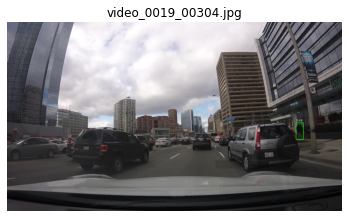

In [4]:
#IMPORTS 
import torch
import torchvision
import os
import json
import cv2
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#CONFIG
IMG_DIR     = 'img'                          # Folder with your images
ANN_PATH    = 'coco_annotations_final.json'  # COCO-style annotations file
CONF_THRES  = 0.3                            # Detection confidence threshold
NUM_IMAGES  = 1                            # Number of valid images to process
SAVE_DIR    = 'retinanet_results'            # Output folder

#DEVICE SETUP
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#LOAD PRETRAINED RETINANET
print("Loading RetinaNet...")
retinanet_model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
retinanet_model.to(device)
retinanet_model.eval()

print("RetinaNet model loaded.\n")
#SAVE RETINANET MODEL LOCALLY 
MODEL_SAVE_PATH = 'retinanet_resnet50_fpn.pth'
torch.save(retinanet_model.state_dict(), MODEL_SAVE_PATH)
print(f"Model weights saved to: {MODEL_SAVE_PATH}")


#LOAD IMAGE FILENAMES FROM COCO JSON
print(f"Reading annotations from: {ANN_PATH}")
with open(ANN_PATH, 'r') as f:
    coco_data = json.load(f)
file_map = {img['id']: img['file_name'] for img in coco_data['images']}

os.makedirs(SAVE_DIR, exist_ok=True)
processed = 0

for img_id, filename in file_map.items():
    if processed >= NUM_IMAGES:
        break

    img_path = os.path.join(IMG_DIR, filename)
    if not os.path.exists(img_path):
        continue

    print(f"\n [{processed+1}/{NUM_IMAGES}] Processing image: {filename}")
    img_cv = cv2.imread(img_path)
    if img_cv is None:
        print(f"Failed to read image: {filename} — skipping.")
        continue

    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).to(device)

    with torch.no_grad():
        preds = retinanet_model([img_tensor])[0]

    boxes = preds['boxes']
    scores = preds['scores']
    labels = preds['labels']

    if len(boxes) == 0 or all(score < CONF_THRES for score in scores):
        print("No detections above threshold — raw image will be saved.")
    else:
        print(f" {sum(score >= CONF_THRES for score in scores)} detections above threshold.")

    # ─── DRAW BOXES ──────────────────────────────────────
    for box, score, label in zip(boxes, scores, labels):
        if score < CONF_THRES or label.item() != 1:
            continue
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_cv, f"{score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # ─── SAVE + SHOW ─────────────────────────────────────
    output_path = os.path.join(SAVE_DIR, filename)
    cv2.imwrite(output_path, img_cv)
    print(f" Saved: {output_path}")

    img_disp = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.imshow(img_disp)
    plt.title(filename)
    plt.axis('off')
    plt.show()

    processed += 1



In [27]:
def evaluate_retinanet_detector(model, img_dir, image_list, gt_boxes_dict, device, iou_thresh=0.5, conf_thresh=0.3):
    from torchvision.ops import box_iou
    import time
    print("device-",device)

    model.eval()
    TP = FP = FN = 0
    total_time = 0
    total_iou = []

    transform = transforms.ToTensor()

    for fname in tqdm(image_list, desc="RetinaNet Evaluation"):
        img_path = os.path.join(img_dir, fname)
        if not os.path.isfile(img_path):
            continue

        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        start = time.time()
        with torch.no_grad():
            outputs = model(img_tensor)[0]
        total_time += time.time() - start

        boxes  = outputs["boxes"]
        scores = outputs["scores"]
        labels = outputs["labels"]

        # Filter by confidence and label (class = 1 = pedestrian)
        pred_boxes = [b for b, s, l in zip(boxes, scores, labels)
                      if s >= conf_thresh and l.item() == 1]
        pred_boxes = torch.stack(pred_boxes).to(device) if pred_boxes else torch.zeros((0, 4), device=device)

        gt_boxes = gt_boxes_dict.get(fname, [])
        gt_boxes = torch.stack(gt_boxes).to(device) if gt_boxes else torch.zeros((0, 4), device=device)

        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            continue
        if len(gt_boxes) == 0:
            FP += len(pred_boxes)
            continue
        if len(pred_boxes) == 0:
            FN += len(gt_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        total_iou.append(ious.mean().item())

        matched = set()
        for i, pbox in enumerate(pred_boxes):
            iou_vals = box_iou(pbox.unsqueeze(0), gt_boxes)
            max_iou, idx = iou_vals.max(1)
            if max_iou.item() >= iou_thresh and idx.item() not in matched:
                TP += 1
                matched.add(idx.item())
            else:
                FP += 1
        FN += len(gt_boxes) - len(matched)

    precision = TP / (TP + FP + 1e-6)
    recall    = TP / (TP + FN + 1e-6)
    f1        = 2 * precision * recall / (precision + recall + 1e-6)
    accuracy  = TP / (TP + FP + FN + 1e-6)
    fps       = len(image_list) / total_time if total_time > 0 else 0.0
    avg_iou   = sum(total_iou) / len(total_iou) if total_iou else 0.0

    print("\n📊 RetinaNet Metrics:")
    print(f"Avg IoU     : {avg_iou:.4f}")
    print(f"Precision   : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-Score    : {f1:.4f}")
    print(f"FPS         : {fps:.2f}")

    return {
        "avg_iou": avg_iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "fps": fps
    }


In [28]:
# Load your COCO-style JSON
import json
from torchvision import transforms


with open("coco_annotations_final.json") as f:
    coco = json.load(f)

# Build GT dict
from collections import defaultdict
import torch

gt_boxes_dict = defaultdict(list)
for ann in coco["annotations"]:
    file_name = next(img["file_name"] for img in coco["images"] if img["id"] == ann["image_id"])
    x, y, w, h = ann["bbox"]
    gt_boxes_dict[file_name].append(torch.tensor([x, y, x + w, y + h]))

# Optional: Filter out images with no GT
filtered_gt_boxes_dict = {k: v for k, v in gt_boxes_dict.items() if len(v) > 0}

# Then define image_subset
image_subset = list(filtered_gt_boxes_dict.keys())

metrics_retina = evaluate_retinanet_detector(
    model=retinanet_model,
    img_dir="images",
    image_list=image_subset,
    gt_boxes_dict=filtered_gt_boxes_dict,
    device=device,
    iou_thresh=0.5,
    conf_thresh=0.3
)


device- cuda


RetinaNet Evaluation: 100%|██████████| 67731/67731 [08:00<00:00, 141.08it/s] 


📊 RetinaNet Metrics:
Avg IoU     : 0.1989
Precision   : 0.2104
Recall      : 0.8099
F1-Score    : 0.3340
FPS         : 313.68
